In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
from scipy.stats import zscore  # To explore the dataset and spot ouliers

# Import label encoder
from sklearn import preprocessing #To apply it to categorical variables

#For Logistic Regression
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
                         summarize)

import warnings
warnings.filterwarnings('ignore')  # mute warning messages

import math


In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('../Customer_Behavior.db')

# Define your SQL query
query = "SELECT * FROM E_Comm_Customer_Behavior"

# Use pandas to execute the query and read the data into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()


### Exploratory Data Analysis
* Understand variable type 
* Check for missing values or errors in data
* Identify outliers 
* Spot duplicate values

In [6]:
df.shape

(350, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               350 non-null    int64  
 1   Gender                    350 non-null    object 
 2   Age                       350 non-null    int64  
 3   City                      350 non-null    object 
 4   Membership Type           350 non-null    object 
 5   Total Spend               350 non-null    float64
 6   Items Purchased           350 non-null    int64  
 7   Average Rating            350 non-null    float64
 8   Discount Applied          350 non-null    object 
 9   Days Since Last Purchase  350 non-null    int64  
 10  Satisfaction Level        348 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 30.2+ KB


In [5]:
df.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14,4.6,TRUE,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,FALSE,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,TRUE,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,FALSE,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,TRUE,55,Unsatisfied


The customer behavior dataset has 350 rows and 11 columns. The dataset contains 6 numerical variables and 5 categorical variables. From above outputs we can see that all variables are stored in the correct data type, and that there are no null values in the dataset

In [9]:
df["Customer ID"].nunique()

350

Given that there are 350 unique Customer IDs in the dataset, and the dataset contains 350 rows. We know there are no duplicate records in this dataset

In [8]:
df.describe()

,Customer ID,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,275.500000,33.597143,845.381714,12.600000,4.019143,26.588571
std,101.180532,4.870882,362.058695,4.155984,0.580539,13.440813
min,101.000000,26.000000,410.800000,7.000000,3.000000,9.000000
25%,188.250000,30.000000,502.000000,9.000000,3.500000,15.000000
50%,275.500000,32.500000,775.200000,12.000000,4.100000,23.000000
75%,362.750000,37.000000,1160.600000,15.000000,4.500000,38.000000
max,450.000000,43.000000,1520.100000,21.000000,4.900000,63.000000


Looking at the summarized statistics of the numerical variables, we can see values under the Age column are reasonable to expect of a ecommerce shopper, e.g. no one under 12 or above 100 year old. Total spending of a consumer seems to range between $410 and $1520 while items purchased quantity range between 7 to 21. Overall, customers gave the products they purchased a rating between between 3 to 4.9. Customers typically make another purchase in a window of 9 to 63 days.

In [11]:
#select the categorical variables
cat = df.select_dtypes(include='object').columns
cat

Index(['Gender', 'City', 'Membership Type', 'Discount Applied',
       'Satisfaction Level'],
      dtype='object')

Gender


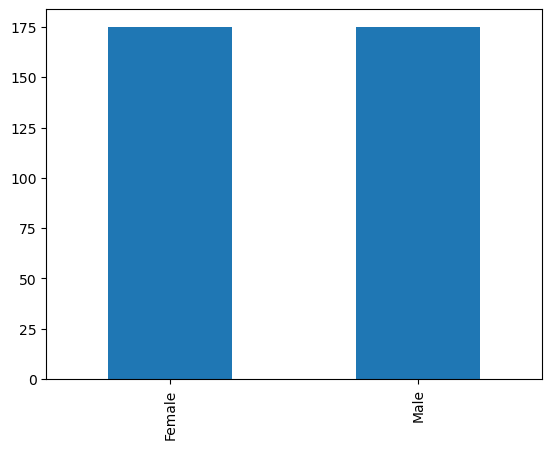

City


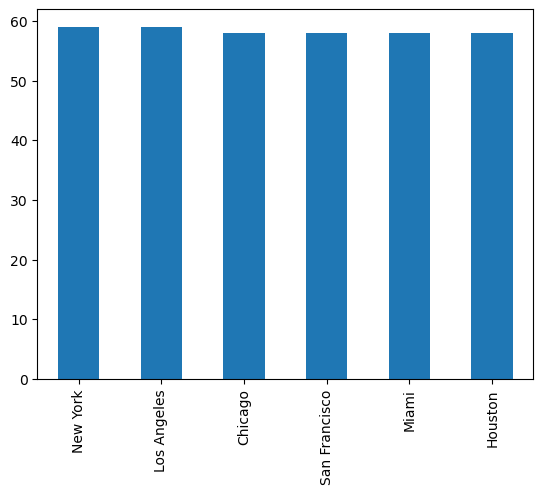

Membership Type


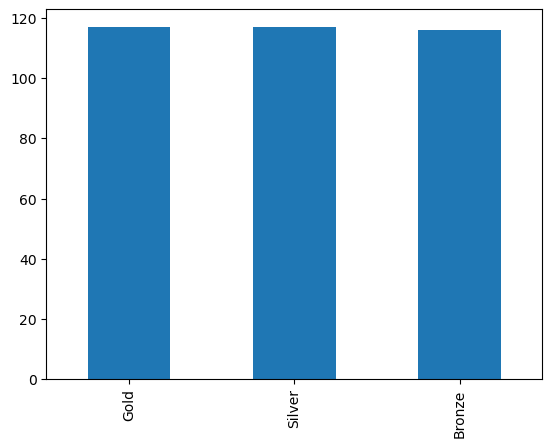

Discount Applied


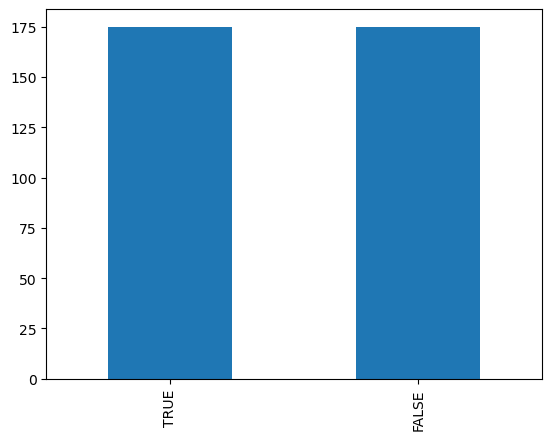

Satisfaction Level


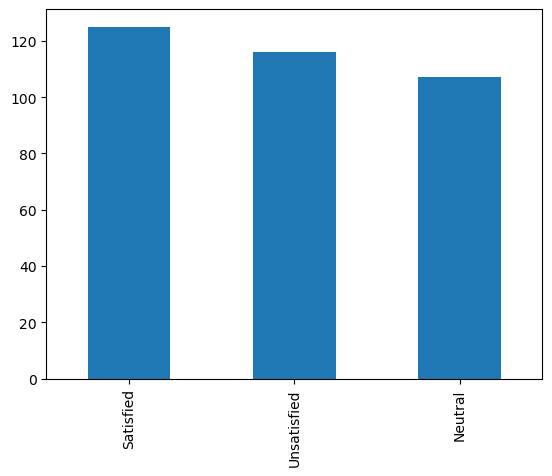

In [12]:
#visualize the distribution of each categorical variable
for c in cat:
    df[c].value_counts().plot.bar()
    print(c)
    plt.show()

We can see that the consumer dataset has the same number of male and female customers, and that there are about the same number of customers located in 6 different cities. Additionally, there are about the same number of customers for each membership type. Half of the customers received discounts, and overall, there are more customers satisfied with the purchase than those who don't. 

In [18]:
#select the numerical variables
num = df.drop('Customer ID', axis=1).select_dtypes(include=np.number).columns
num

Index(['Age', 'Total Spend', 'Items Purchased', 'Average Rating',
       'Days Since Last Purchase'],
      dtype='object')

Age


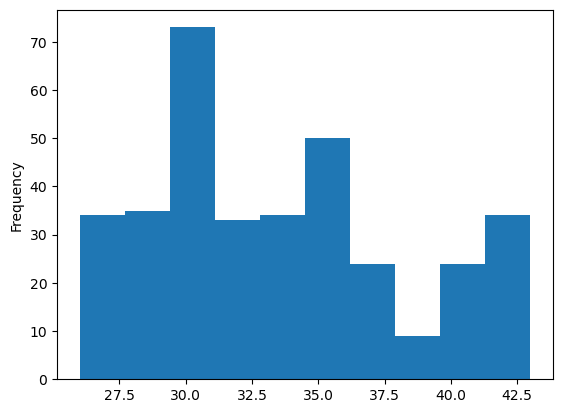

Total Spend


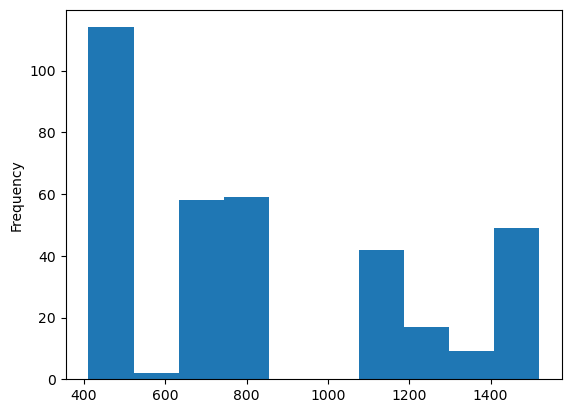

Items Purchased


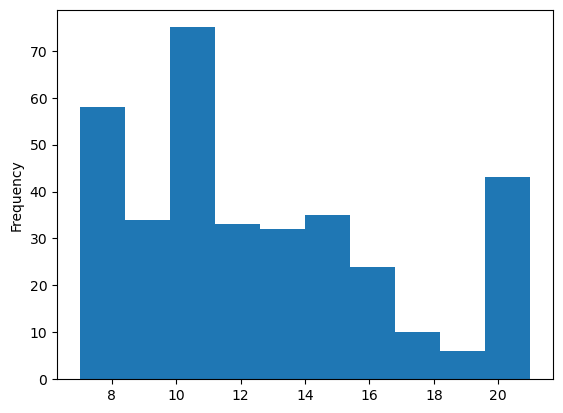

Average Rating


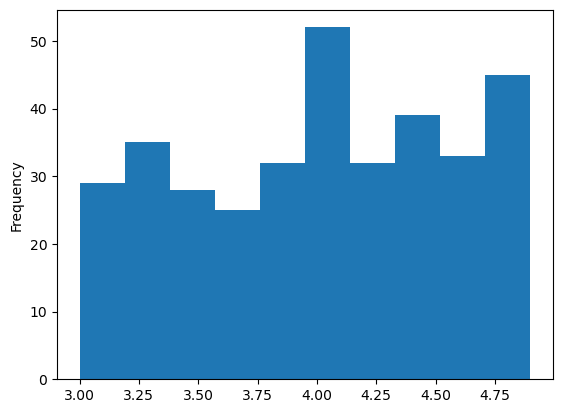

Days Since Last Purchase


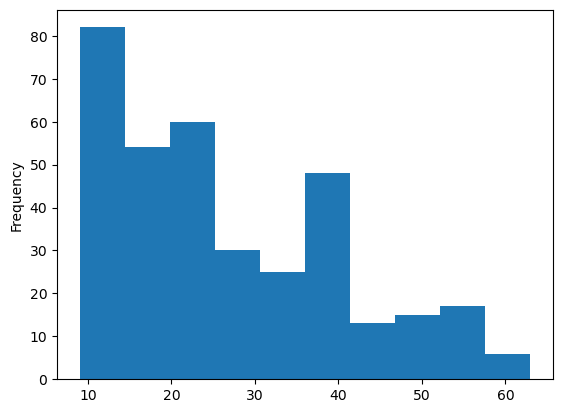

In [20]:
#plot histogram for numerical variables
for n in num: 
    df[n].plot.hist(bins=10)
    print(n)
    plt.show()

### Analysis Objective
The motivation behind our analysis is to understand whether certain demographic variables - Age, City, Gender, are powerful predictors of a customer being a high spender. In other words, a high value customer as defiend in marketing terms. Identifying high value customers are important for a company since these customers bring in the most revenue to the company over time. Using statistical analysis, we aim to identify statistically signficant demographic variables in determining a high value customer. In doing so, the company can develop retention strategy that target potential high value customers who fit the demographic profile of a high value customer, which will in turn boost the company's total revenue. 

In [10]:
#Creating a high value of purchase based on the threshold of Purchases > 1400
#High Purchase == 1 when > 1400
df['High_Purchase'] = df['Total Spend'].apply(lambda x: 1 if x > 1400 else 0)



In [8]:
#check the average total spend of male and female customers
df.groupby('Gender').agg({'Total Spend':np.mean})


,Total Spend
Gender,
Female,703.828571
Male,986.934857


It appears on average male customers spend more than female customers, we'll run a regression to determine whether male customer has a higher chance of being a high value customer.

In [9]:
#Applying Label Enconder to gender
label_encoder = preprocessing.LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Gender'].unique()


array([0, 1])

In [11]:
from sklearn.model_selection import train_test_split

In [29]:
y = df['High_Purchase']
x = df.iloc[:,0:2].drop('Customer ID', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [16]:
from sklearn.linear_model import LogisticRegression

In [31]:
model = LogisticRegression()
#fit the model with data
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [32]:
from sklearn import metrics
acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy :", acc)

Accuracy : 0.8522727272727273


### Results Interpretation
Since the accuracy is roughly 85%, we can conclude gender is a good predictor for a high value customer. However, given the small sample size, we have to take the result of the model with a grain of salt. 

### Logistic Regression

#### Definitions:

$y$ = total spent > 1400 <br>
$X$ = Gender_encoded

In [7]:
#df['High_Purchase'].to_numpy()
df['High_Purchase']


0      0
1      0
2      0
3      1
4      0
      ..
345    0
346    0
347    0
348    0
349    0
Name: High_Purchase, Length: 350, dtype: int64

In [8]:
y = df['High_Purchase']
X = df['Age']
glm = sm.Logit(y, X)

# # or equally:
# glm = sm.GLM(y,
#              X,
#              family=sm.families.Binomial())
results = glm.fit()
summarize(results)


Optimization terminated successfully.
         Current function value: 0.374032
         Iterations 6


,coef,std err,z,P>|z|
Age,-0.0586,0.005,-11.919,0.0


In [9]:
results.pvalues


Age    9.428357e-33
dtype: float64

In [10]:
results.params


Age   -0.05861
dtype: float64

##### Odds ratio
$e{^-0.05861}$ ≈ 0.943

In [17]:
#Odds ratio
(1 - math.exp(-0.05861)) * 100


5.69255035007582

#### Results interpretation

* **Age coef**: Suggests that as the age increases the likelyhood of a high purchase (==1) decreases.
* **str err**: Suggests that the coeficient estime is relatively precise.
* **Z-Value**: Indicates a that its distance is far from zero and it is likely significant.
* **P-Value**: Probability the coefficient is far from 0 and significant, i.e., it is statistically significant. Given the p-value is essentially 0, you can conclude that the relationship between age and high purchase is statistically significant.
* **Odds ratio**: For each year of age the odds of making a high purchase decrease about 5.7%

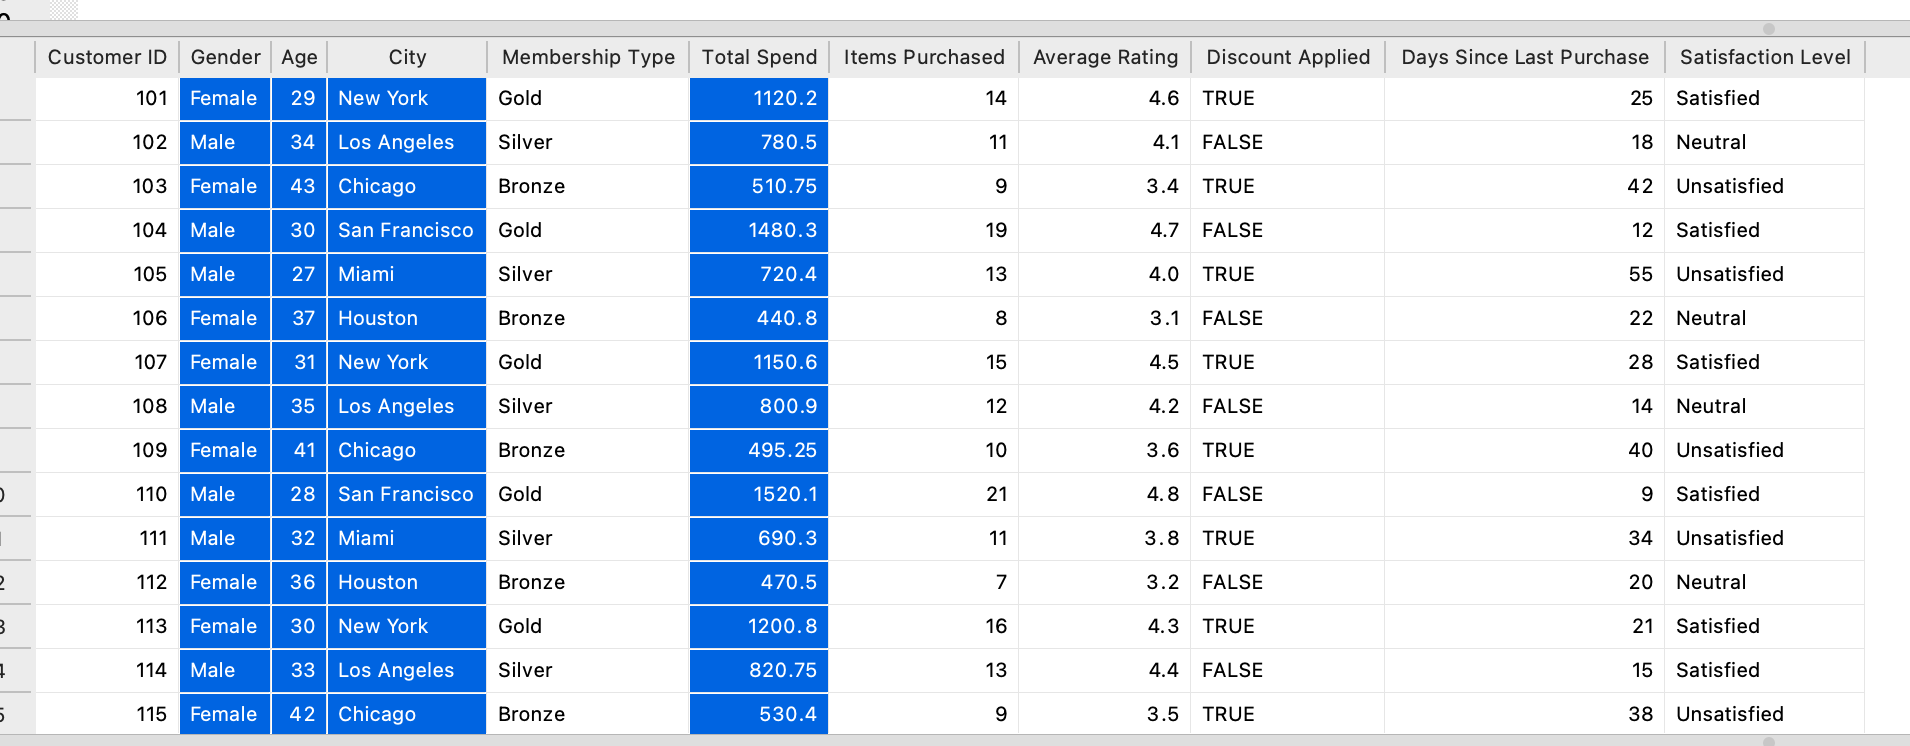